In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

In [3]:
## Load and prepare data.
data = read_csv(os.path.join('data', 'data.csv'))

## Apply rejections.
reject = read_csv(os.path.join('data', 'reject.csv'))
data = data.loc[data.subject.isin(reject.query('reject==0').subject)]

## Score missing data.
data['accuracy'] = data['accuracy'].fillna(0)

#### rt explorations

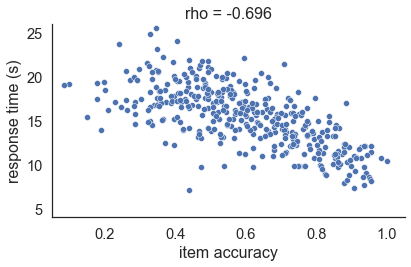

In [28]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Compute item statistics.
agg = {'rt':'median','accuracy':'mean'} 
gb = data.groupby('item_id').agg(agg)
rho = gb.corr(method='spearman').loc['rt','accuracy']

## Plot item statistics.
sns.scatterplot(x='accuracy', y='rt', data=gb, ax=ax)

## Add detail.
ax.set(xlim=(0.05,1.05), xlabel='item accuracy', ylim=(4,26), 
       ylabel='response time (s)', title='rho = %0.3f' %rho)

sns.despine()
plt.tight_layout()

<AxesSubplot:xlabel='rt', ylabel='Density'>

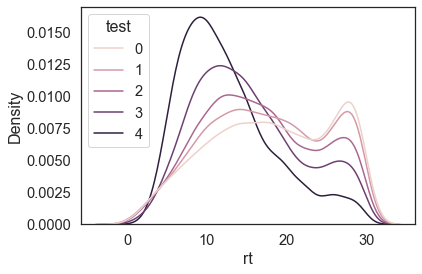

In [5]:
bins = data.groupby('item_id').accuracy.mean().quantile(np.arange(0.2,1.0,0.2))
f = lambda x: np.digitize(x.mean(), bins)
data['test'] = data.groupby('item_id').accuracy.transform(f)
sns.kdeplot(x='rt', hue='test', data=data)

<AxesSubplot:xlabel='drt', ylabel='accuracy'>

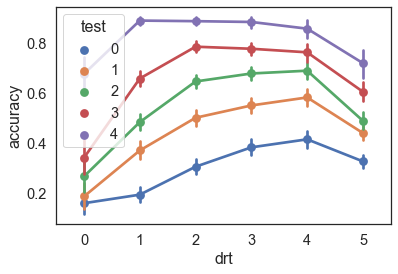

In [6]:
data['drt'] = np.digitize(data.rt, np.arange(5, 30, 5))
sns.pointplot(x='drt', y='accuracy', hue='test', data=data)

<AxesSubplot:ylabel='accuracy'>

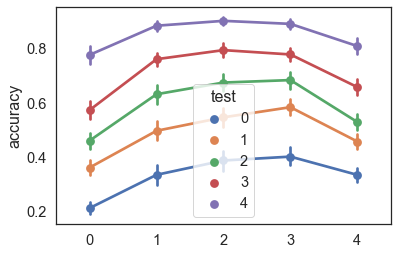

In [7]:
data['rt_demean'] = data.groupby('item_id').rt.transform(lambda x: x - x.mean())
sns.pointplot(
    x=np.digitize(data.rt_demean, data.rt_demean.quantile(np.arange(0.2,1.0,0.2))),
    y=data.accuracy,
    hue=data.test
)

one idea is to model response times. through incorporating subject ability as regressor, then we can better resolve the subject ability terms. In doing so, the hope would be that we would have more power to resolve the discrimination parameter. 

intuitively, the relationships should be something like: 
- item difficulty determines mean response time
- subject ability helps determine dispersion around mean

the weird thing you want to be able to predict is that lower ability individuals should be at either end of the distribution. that is, fast responses are more likely to be inaccurate and from low ability participants. similarly, slow responses are more likely to be inaccurate and from low ability participants.

the trickiness here is that these should be from very different proceses. fast responses should be guessing, slow responses should be from lower ability.

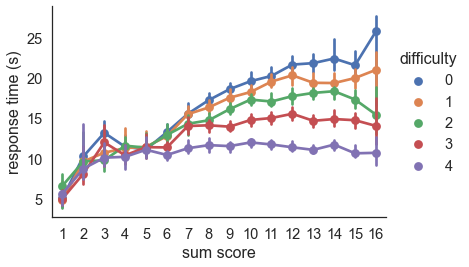

In [29]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(7,4))

## Compute sum scores.
data['sum_score'] = data.groupby('subject').accuracy.transform(np.sum)

## Plot RTs by score.
sns.pointplot(x='sum_score', y='rt', hue='test', data=data, estimator=np.median)

ax.set(xticklabels=np.arange(1,17), xlabel='sum score', ylabel='response time (s)')
ax.legend(loc=7, bbox_to_anchor=(1.25,0.5), title='difficulty', frameon=False)

sns.despine()
plt.tight_layout()

In [ ]:
from scipy.stats import spearmanr

fig, ax = plt.subplots(1,1,figsize=(6,4))

data['iia'] = data.groupby('item_id').accuracy.transform(np.mean)
f = lambda x: x[['iia','rt']].corr().iloc[0,1]
corr = data.groupby('subject').apply(f)
scores = data.groupby('subject').accuracy.sum()

sns.pointplot(x=scores, y=corr)
ax.set(xticklabels=np.arange(1,17), xlabel='sum score', ylabel='corr(RT, Difficulty)')

spearmanr(corr, scores)

sns.despine()
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

agg = {'accuracy':'sum', 'rt':'median'}
gb = data.groupby('subject').agg(agg)

sns.stripplot(x='accuracy', y='rt', data=gb, s=3, jitter=0.3, zorder=-1)
sns.pointplot(x='accuracy', y='rt', data=gb, ci=None, estimator=np.median, color='0.4')
ax.set(xticklabels=np.arange(1,17), xlabel='sum score', ylabel='response time')

sns.despine()